James Telzrow \
2023-07-05 \
Warburton Lab \
Fourier Grid Hamiltonian Implementation

This is fairly close to completion.
However, I'm not sure about whether unit labels are accurate.
(For example, is the mass really in atomic units, the step size really in Angstroms, etc...)

In [88]:
# Indicates whether this code should attempt to retrieve data from a 
# json file, or calculate it itself.
read_from_json = False

if read_from_json:

    import json
    import numpy as np

    # The name of the json file from which data should be read. Unless a
    # path to the file is given, the file must be in the same directory 
    # as this notebook.
    json_file_name = 'fgh_data_2023-07-06_12-42-10.json'
    with open(json_file_name, 'r') as file:
        json_data = json.load(file)
        potential_energy_data = json_data['potential_energy_data']
        interval_for_sol = json_data['interval_for_sol']
        energy_levels_to_plot = json_data['energy_levels_to_plot']
        mass = json_data['mass']
        step_size = json_data['step_size']
        hamiltonian = np.array(ast.literal_eval(json_data['hamiltonian_str']))
        hamiltonian_eigenvals = np.array(ast.literal_eval(json_data['hamiltonian_eigenvals_str']))
        hamiltonian_eigenvects = np.array(ast.literal_eval(json_data['hamiltonian_eigenvects_str']))

In [ ]:
if read_from_json:
    raise RuntimeError('You are running a cell which creates variables for parameter values using supplied literals (NOT from a json file). However, read_from_json is True, indicating that you instead wish to use values saved in a json file. To run this cell, set read_from_json to False in the cell above.')

# A list of potential energy datapoints. The first element in each 
# datapoint should be a position on the x-axis (in Angstroms) and the 
# second element should be the amount of potential energy that the 
# particle possesses (in electronvolts) when it is at that position
potential_energy_data = [
    [-5, 25],
    [-4, 16],
    [-3, 9],
    [-2, 4],
    [-1, 1],
    [0, 0],
    [1, 1],
    [2, 4],
    [3, 9],
    [4, 16],
    [5, 25],
]

# The interval on which the wavefunctions will be found (on the x-axis, 
# in Angstroms)
interval_for_sol = [-3, 3]
# The indices of the energy levels for which to plot wavefunctions, from
# a zero-indexed list of energy levels (in electron volts) sorted by 
# increasing magnitude.
energy_levels_to_plot = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# The mass of the particle, in atomic units
mass = 0.0005
# The magnitude of the difference between adjacent points on the x-axis 
# at which the wavefunction values will be computed, in Angstroms
step_size = 0.01

# Indicates whether the calculated data should be stored in a json file,
# so it can be later re-opened by this notebook without time-consuming 
# recalculation of the Hamiltonian matrix
save_data_to_json = True

In [ ]:
if read_from_json:
    raise RuntimeError('You are running a cell which does calculations in preparation for computing the Hamiltonian matrix. However, read_from_json is True, indicating that you instead wish to use a Hamiltonian matrix stored in a json file. To run this cell, set read_from_json to False two cells above.')

import math
import numpy as np
from scipy.interpolate import CubicSpline

# Convert atomic units to kilograms
m = mass * 1.660_540_199e-27
# Convert Angstroms to meters 
delta_x = step_size * 1e-10

p_e_d = np.array(potential_energy_data).astype(np.float64)
# Convert Angstroms to meters
p_e_d[:, :1] *= 1e-10
# Convert electronvolts to Joules
p_e_d[:, 1:2] *= 1.602_176_634e-19
potential_energy_cs = CubicSpline(p_e_d[:, :1].flatten(), p_e_d[:, 1:2].flatten(), extrapolate=True)

def potential(x) -> float:
    # Gives the potential energy of the particle, given its position on 
    # the x-axis
    return potential_energy_cs(x)

def kronecker_delta_function(coords: [int]):
    if coords[0] == coords[1]:
        return 1
    else:
        return 0

#Convert Angstroms to meters
interval_lower_bound = interval_for_sol[0] * 1e-10
interval_upper_bound = interval_for_sol[1] * 1e-10
# The points on the x-axis at which the values of the wavefunctions will
# be found
grid_points = np.arange(interval_lower_bound, interval_upper_bound, delta_x)
# The algorithm requires an odd number of grid points; drop one if 
# arange returns an even number of points
if grid_points.size % 2 != 1:
    grid_points = grid_points[:-1]

# Make sure the user hasn't asked for an energy level higher than that 
# which we are able to find
for e_lvl in energy_levels_to_plot:
    if (e_lvl > grid_points.size - 1):
        int_ln = interval_for_sol[1] - interval_for_sol[0]
        raise ValueError('Because the specified interval is {} Angstroms long and the specified step size is {}, this method can compute only {} energy levels. However, energy_levels_to_plot contains the value {}, which is an energy level higher than that which can be computed using this method. Please remove that value from energy_levels_to_plot and try again.'.format(int_ln, delta_x, grid_points.size, e_lvl))

# The result of this is technically a float, but because 
# grid_points.size is always odd, we can cast this to an integer without
# losing any information
N = grid_points.size
n = int((N - 1)/2)

# Reduced Planck constant, in Joule seconds
hbar = 1.054_571_817e-34

# The element at position [x, y] in this array will be the 2-element 
# array [x, y].
matrix_indices = np.indices((N, N)).transpose((1, 2, 0))
# Equivalent to iterating across each row of the matrix above, and 
# adding every 2-element array to a one-dimensional list
matrix_indices = matrix_indices.reshape((N**2, 2))

# Create an empty matrix that will become the Hamiltonian matrix once 
# elements are calculated by the code below
hamiltonian = np.zeros((N, N))

In [92]:
def compute_hamiltonian_sum_term(summation_index, i, j):
    # Returns the summation_index-th term within the summation in 
    # Equation 26 in source [1]
    l = summation_index
    T_l = (2/m)*((hbar*math.pi*l)/(N*delta_x))**2
    return math.cos(l*2*math.pi*(i - j)/N)*T_l

def compute_unique_hamiltonian_element(coords):
    # Compute the element in the coords[0]th row and coords[1] column of
    # the Hamiltonian matrix, according to Equation 26 in source [1]
    # 
    # Since the Hamiltonian matrix is Hermetian, it equals its conjugate
    # transpose. So we don't compute elements below the main diagonal; 
    # we just wait until we have computed every element above the main 
    # diagonal and then to find the element at position [i, j] (with i <
    # j) we simply take the conjugate of the element at position [j, i].
    if coords[0] <= coords[1]:
        summation_indices = np.arange(1, n+1)
        # Vectorize the function that returns the terms in the sum
        v_c_h_s_t = np.vectorize(compute_hamiltonian_sum_term)
        # Exclude the Hamiltonian row and column indices from 
        # vectorization, since we specify scalar values for these for 
        # each summation_indices array over which we vectorize
        v_c_h_s_t.excluded.add((1, 2))
        sum = (2/N)*v_c_h_s_t(summation_indices, *coords).sum()
        sum += potential(grid_points[coords[0]])*kronecker_delta_function(coords)
        hamiltonian[*coords] = sum

def compute_conjugate_hamiltonian_element(coords):
    # Fills in the elements below the main diagonal in the Hermetian 
    # matrix, according to Equation 26 in source [1]. Because this takes
    # advantage of the Hamiltonian matrix's Hermetian nature, it should 
    # be used ONLY AFTER compute_unique_hamiltonian_element has been 
    # run.
    #
    # Since all elements of the Hamiltonian matrix (which must be 
    # Hermetian) are real, then the element in the ith row and jth 
    # column (for i > j) is the element in the jth row and ith column
    if coords[0] > coords[1]:
        hamiltonian[*coords] = hamiltonian[*coords[::-1]]

In [ ]:
if read_from_json:
    raise RuntimeError('You are trying to write Hamiltonian data to a json file. However, read_from_json is True, meaning that the data you are trying to write was just read from a json file. To run this cell, set read_from_json to False four cells above.')

import datetime
import json

def save_to_json():
    # Write data to a JSON file, so we can quickly load it instead of 
    # calculating it again
    data_dict = {
        'potential_energy_data': potential_energy_data,
        'interval_for_sol': interval_for_sol,
        'energy_levels_to_plot': energy_levels_to_plot,
        'mass': mass,
        'step_size': step_size,
        'hamiltonian_str': str(hamiltonian.tolist()),
        'hamiltonian_eigenvals_str': str(hamiltonian_eigenvals.tolist()),
        'hamiltonian_eigenvects_str': str(hamiltonian_eigenvects.tolist()),
    }
    data_json = json.dumps(data_dict)
    with open('fgh_data_{date:%Y-%m-%d_%H-%M-%S}.json'.format(date=datetime.datetime.now()), 'w') as file:
        file.write(data_json)

if save_data_to_json:
    save_to_json()

In [ ]:
if read_from_json:
    raise RuntimeError('You are running a cell calculates the Hamiltonian matrix. However, read_from_json is True, indicating that you instead wish to use a Hamiltonian matrix stored in a json file. To run this cell, set read_from_json to False two cells above.')

# Compute the elements of the Hamiltonian matrix on and above the main 
# diagonal
np.apply_along_axis(compute_unique_hamiltonian_element, 1, matrix_indices)
# Compute the elements of the Hamiltonian matrix below the main diagonal
# (very simple because the matrix is Hermetian and has all real 
# elements)
np.apply_along_axis(compute_conjugate_hamiltonian_element, 1, matrix_indices)
# Find the eigenvalues (energy levels) and eigenvectors (wave functions)
# of the Hamiltonian matrix
from scipy import linalg
hamiltonian_eig = linalg.eig(hamiltonian)
hamiltonian_eigenvals = hamiltonian_eig[0]
hamiltonian_eigenvects = hamiltonian_eig[1]

Energy levels: (in electron volts)
Energy level 0: 1.9102994758878404
Energy level 1: 6.95200970479367
Energy level 2: 8.767963866595837
Energy level 3: 21.318102461190275
Energy level 4: 21.679548776652666
Energy level 5: 44.36758184007565
Energy level 6: 44.493528636721784
Energy level 7: 76.57303722816377
Energy level 8: 76.63749288229715
Energy level 9: 117.97057822060845
Energy level 10: 118.01009877426256
Energy level 11: 168.5650757837309


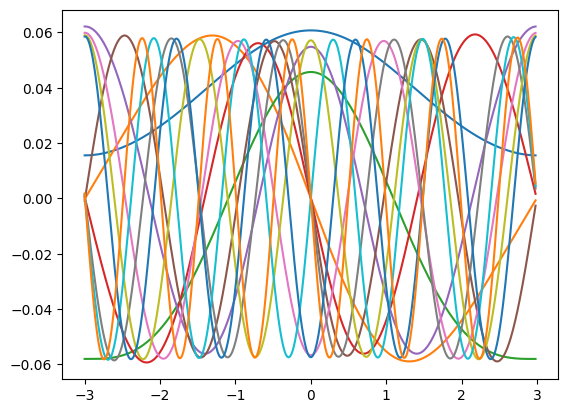

In [96]:
import matplotlib.pyplot as plt

# Plot the solutions for the specified energy levels. Note that the 
# energy levels returned by linalg.eig aren't ordered from smallest to 
# largest by magnitude. Thus we use argsort to find the permutation of 
# indices that would rearrange the energy levels in this way, and then 
# we use these indices to find the corresponding eigenvectors for the 
# specified energy levels. Then we plot the components of these 
# eigenvectors.
# Also, print the amount of energy the particle has at each energy 
# level.
print('Energy levels: (in electron volts)')
for e_lvl, eigenval_index in enumerate(hamiltonian_eigenvals.argsort().take(energy_levels_to_plot)):
    # Convert Joules to electron volts
    print('Energy level {}: {}'.format(e_lvl, abs(hamiltonian_eigenvals[eigenval_index]*6.241_509_074e18)))
    # Convert meters to Angstroms
    plt.plot(grid_points * 1e10, hamiltonian_eigenvects[:, eigenval_index])

